In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [2]:
original_image = cv2.imread("/content/Image_Original.jpg")

# **BINARY MASKING OF THE IMAGE**

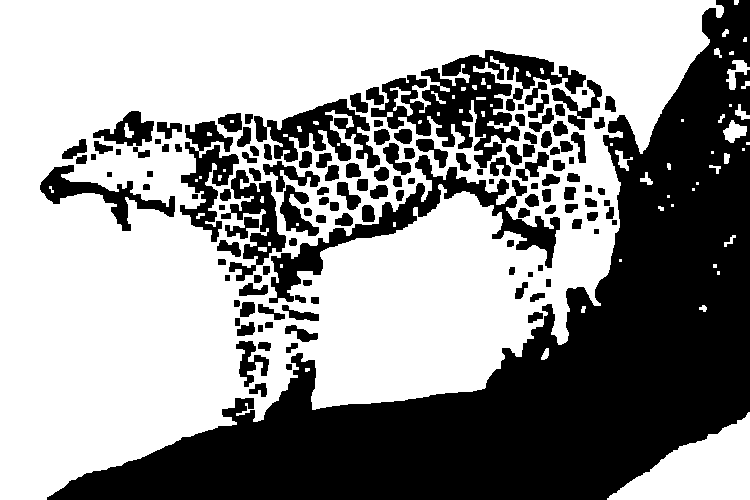

In [10]:
image = original_image

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary_mask = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

cv2.imwrite('binary_mask.jpg', binary_mask)
kernel_open = np.ones((3, 3), np.uint8)
opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_open)

kernel_close = np.ones((5, 5), np.uint8)
closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel_close)

cv2.imwrite('refined_spot_mask.jpg', closed_mask)
cv2_imshow(closed_mask)

# **TREE MASK**

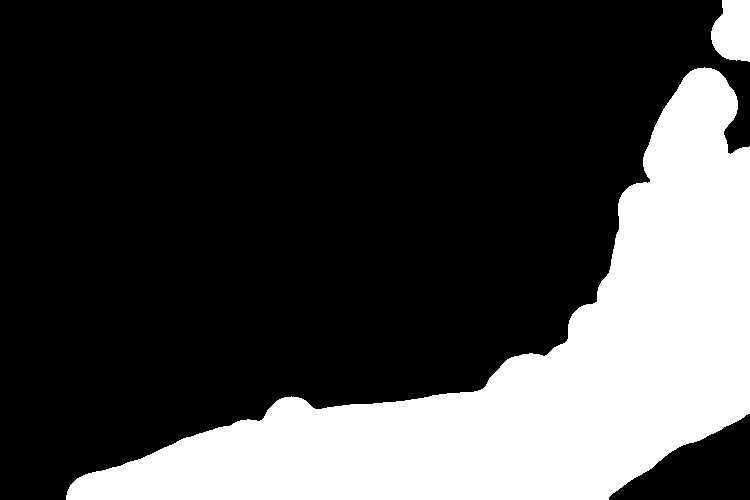

In [11]:
mask = cv2.imread('refined_spot_mask.jpg', cv2.IMREAD_GRAYSCALE)

blurred_mask = cv2.GaussianBlur(mask, (21, 21), 0)

_, thresholded_mask = cv2.threshold(blurred_mask, 120, 255, cv2.THRESH_BINARY)

closing_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (51, 51))
closed_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, closing_kernel)

opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, opening_kernel)

tree_white_mask = cv2.bitwise_not(cleaned_mask)

cv2.imwrite('tree_white_mask.jpg', tree_white_mask)
cv2_imshow(tree_white_mask)

# **FINAL MASK OF THE SPOTS**

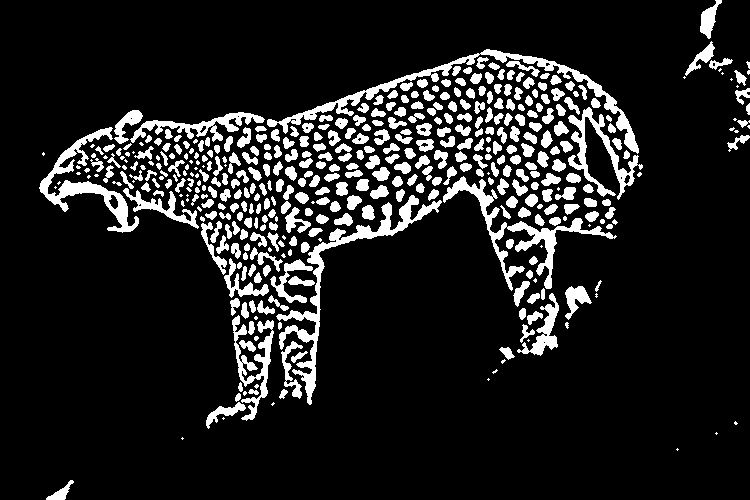

In [12]:

tree_mask = cv2.imread("/content/tree_white_mask.jpg", cv2.IMREAD_GRAYSCALE)

gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
blurred_gray = cv2.GaussianBlur(gray_image, (5, 5), 0)
all_spots_mask = cv2.adaptiveThreshold(
    blurred_gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 31, 5
    )
cv2.imwrite('1_all_spots_detected.png', all_spots_mask)

non_tree_area_mask = cv2.bitwise_not(tree_mask)


final_leopard_spots = cv2.bitwise_and(all_spots_mask, all_spots_mask, mask=non_tree_area_mask)

separating_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
final_leopard_spots_clean = cv2.morphologyEx(final_leopard_spots, cv2.MORPH_OPEN, separating_kernel)

cv2.imwrite('leopard_spots_final.png', final_leopard_spots_clean)
cv2_imshow(final_leopard_spots_clean)

# **DILATION FOLLOWED BY INPAINTING OF THE SPOTS**

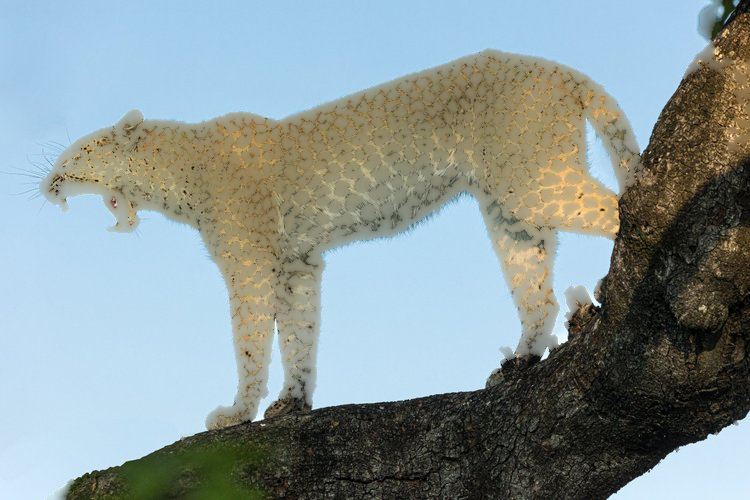

In [13]:

spot_mask_for_inpainting = cv2.imread("/content/leopard_spots_final.png", cv2.IMREAD_GRAYSCALE)

hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
lower_bound = np.array([10, 40, 40])
upper_bound = np.array([40, 255, 255])
color_segmentation_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

closing_kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (35, 35))
closed_leopard_area = cv2.morphologyEx(color_segmentation_mask, cv2.MORPH_CLOSE, closing_kernel_large)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_leopard_area, 8, cv2.CV_32S)

if num_labels > 1:
    largest_component_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    leopard_body_mask = np.zeros_like(closed_leopard_area)
    leopard_body_mask[labels == largest_component_label] = 255
else:
    leopard_body_mask = closed_leopard_area

leopard_body_mask = cv2.morphologyEx(leopard_body_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))
leopard_body_mask = cv2.morphologyEx(leopard_body_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)))

cv2.imwrite('leopard_body_mask_clean.png', leopard_body_mask)

dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))


dense_spot_mask = cv2.dilate(spot_mask_for_inpainting, dilation_kernel, iterations=1)

cv2.imwrite('dense_spot_mask.png', dense_spot_mask)

inpainted_leopard_raw = cv2.inpaint(original_image, dense_spot_mask, 300, cv2.INPAINT_TELEA) # Radius 300
cv2.imwrite('Final_Spotless_Leopard.jpg', inpainted_leopard_raw)
cv2_imshow(inpainted_leopard_raw)
